In [1]:
%pylab inline
import os
import scipy
import h5py
import skimage
import glob
from skimage import io,transform 
from skimage.io import imread,imsave
from collections import OrderedDict

project_dir = os.getcwd()
art_dir = project_dir + '/images/styles/'
photo_dir = project_dir + '/images/content/'
guide_dir = project_dir + '/images/guides/'
out_dir = project_dir + '/images/outputs/'
model_dir = project_dir + '/models/trained/'
if not os.path.isdir(model_dir):
    print('Model dir missing, to get the pretrained models execute the download_leon_models.sh script')
tmp_dir = project_dir + '/tmp/'
if not os.path.isdir(tmp_dir):
    os.makedirs(tmp_dir)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# aux functions
def rgb2luv(image):
    img = image.transpose(2,0,1).reshape(3,-1)
    luv = np.array([[.299, .587, .114],[-.147, -.288, .436],[.615, -.515, -.1]]).dot(img).reshape((3,image.shape[0],image.shape[1]))
    return luv.transpose(1,2,0)
def luv2rgb(image):
    img = image.transpose(2,0,1).reshape(3,-1)
    rgb = np.array([[1, 0, 1.139],[1, -.395, -.580],[1, 2.03, 0]]).dot(img).reshape((3,image.shape[0],image.shape[1]))
    return rgb.transpose(1,2,0)
def list2css(layers):
    '''
    Takes list of strings and returns comma separated string
    '''
    css = str()
    for l in layers:
        css = css+l+','
    return css[:-1]

## Run luminance network

In [3]:
#define model and content image
model = 'candy_lum_256-lum'
image_size = 512
median_filter = 3
input_image = 'afghan_girl_cropped.jpg'
gpu = 0
output_image = (input_image + '_' + 
                model + '_' + 
                str(image_size) + '_' + 
                '.jpg')

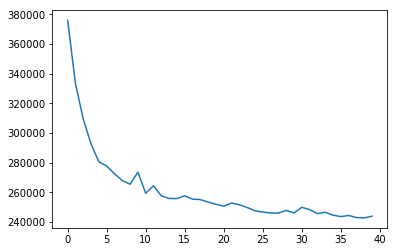

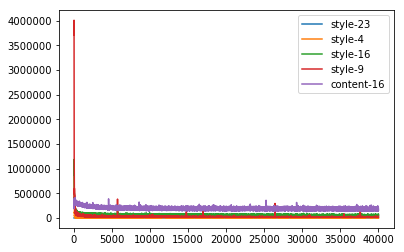

In [4]:
#show training log of model
train_log = model_dir + model + '.json'
import json
with open(train_log) as json_data:
    log = json.load(json_data)
plot(log['val_loss_history'])
show()
#show style loss of individual layers
legend = []
for key in log['style_loss_history'].keys():
    plot(log['style_loss_history'][key])
    legend.append(key)
gca().legend(legend)

Writing output image to /gpfs01/bethge/home/lgatys/NeuralImageSynthesis/fast-neural-style/images/outputs/afghan_girl_cropped.jpg_candy_lum_256-lum_512_.jpg	

real	0m2.960s
user	0m2.615s
sys	0m1.309s


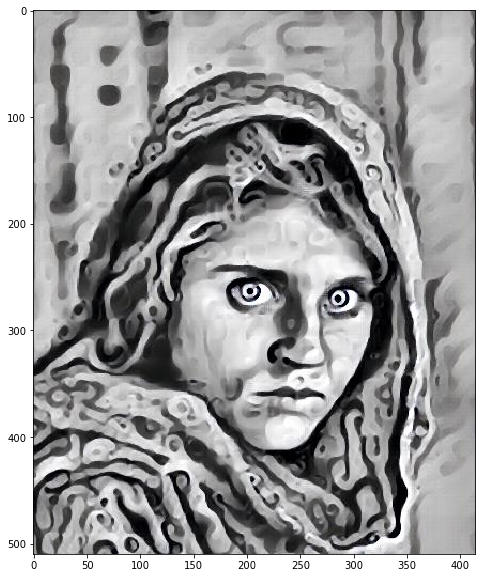

In [5]:
#write script to execute torch code
context = {
    'model': model_dir + model + '.t7',
    'image_size': image_size,
    'median_filter': median_filter,
    'input_image': photo_dir + input_image,
    'output_image': out_dir + output_image,
    'gpu': gpu,
}

template = (
            '#!/bin/bash\n' +
            'time /usr/local/torch/install/bin/th fast_neural_style.lua ' + 
            '-model {model} ' +
            '-image_size {image_size} ' + 
            '-median_filter {median_filter} ' + 
            '-input_image {input_image} ' + 
            '-output_image {output_image} ' + 
            '-gpu {gpu} '
           )

script_name = project_dir + '/run_synthesis.sh'
with open(script_name, 'w') as script:
    script.write(template.format(**context))
os.chmod(script_name, 0o755)
#execute script
!cd {project_dir} && \
./run_synthesis.sh
imshow(imread(out_dir+output_image))
gcf().set_size_inches(10,10)

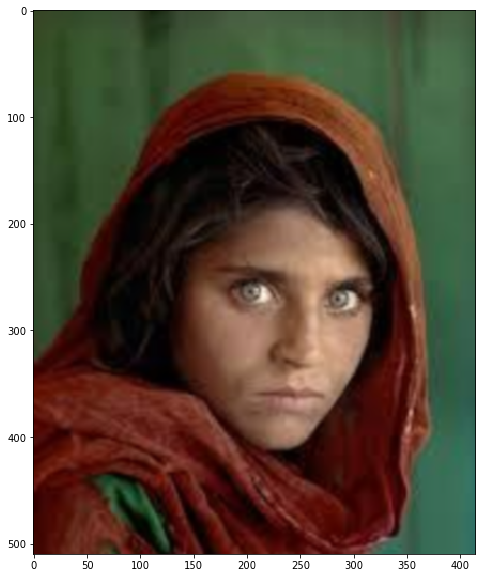

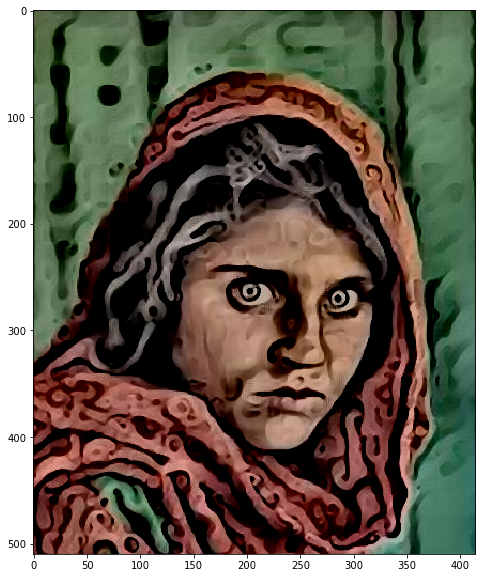

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [6]:
#save color presered output image
output = skimage.img_as_float(imread(out_dir+output_image))
try:
    img = imread(photo_dir + input_image.replace('_lum.jpg','')+'.jpg')
except:
    img = imread(photo_dir + input_image)
try:
    img = transform.pyramid_reduce(img, sqrt(float(img[:,:,0].size) / image_size**2))
except:
    img = transform.pyramid_expand(img, 1./(sqrt(float(img[:,:,0].size) / image_size**2)))

img = skimage.img_as_float(scipy.misc.imresize(img,output.shape))
img_luv = rgb2luv(img)
#match luminance
output -= output.mean(0).mean(0)
output += img_luv[:,:,0].mean()
img_luv[:,:,0] = output.mean(2)
img_new = luv2rgb(img_luv)
img_new[img_new>1]=1
img_new[img_new<0]=0
imshow(img);gcf().set_size_inches(10,10);show()
imshow(img_new);gcf().set_size_inches(10,10);show()
imsave(out_dir + output_image.replace('.jpg','')+'_cp.jpg',img_new)

## Run spatially guided network

In [7]:
#define model and content image
model = 'candy_over_feathers_256_guidance_sw_5.0_slim'
image_size = 512
median_filter = 3
input_image = 'afghan_girl_cropped.jpg'
gpu = 0
output_image = (input_image + '_' + 
                model + '_' + 
                str(image_size) + '_' + 
                '.jpg')

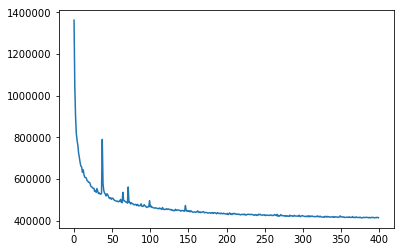

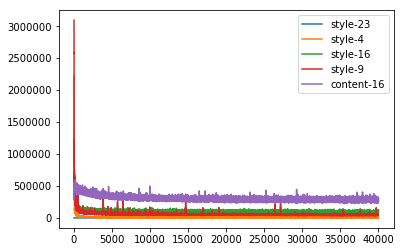

In [8]:
#show training log of model
train_log = model_dir + model + '.json'
import json
with open(train_log) as json_data:
    log = json.load(json_data)
plot(log['val_loss_history'])
show()
#show style loss of individual layers
legend = []
for key in log['style_loss_history'].keys():
    plot(log['style_loss_history'][key])
    legend.append(key)
gca().legend(legend)

In [9]:
# define guidance channels here
guide_image = input_image
guide_names = ['background','person']
# to swap style guidance:
# guide_names = ['person','background']
# use below for simple left/right, top/bottom guidance
# guide_image = 'white_noise.jpg'
# guide_names = ['left','right']
# guide_names = ['top','bottom']
guides = []
for name in guide_names:
    guide = imread(guide_dir+guide_image.replace('.jpg','')+'_'+ name+'.jpg')
    if guide.ndim == 3:
        guide = guide[:,:,0]
    guides.append(guide)
guides = dstack(guides).transpose(2,0,1)
# save guides as hdf5 to load in torch
guides_file_name = tmp_dir + 'guides.hdf5'
f = h5py.File(guides_file_name, 'w')
f.create_dataset('guides', data=guides)
f.close()
output_image = (input_image + '_' + 
                model + '_' + 
                str(image_size) + '_' + 
                list2css(guide_names) + 
                '.jpg')

Writing output image to /gpfs01/bethge/home/lgatys/NeuralImageSynthesis/fast-neural-style/images/outputs/afghan_girl_cropped.jpg_candy_over_feathers_256_guidance_sw_5.0_slim_512_background,person.jpg	

real	0m3.027s
user	0m2.738s
sys	0m1.346s


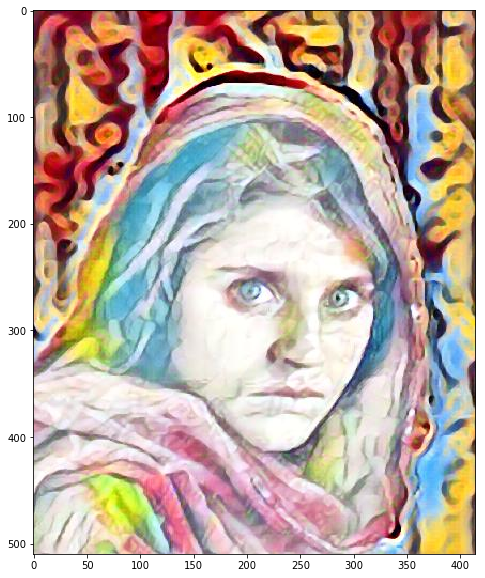

In [10]:
#write script to execute torch code
context = {
    'model': model_dir + model + '.t7',
    'image_size': image_size,
    'median_filter': median_filter,
    'input_image': photo_dir + input_image,
    'input_image_guides': guides_file_name,
    'output_image': out_dir + output_image,
    'gpu': gpu,
}

template = (
            '#!/bin/bash\n' +
            'time /usr/local/torch/install/bin/th fast_neural_style.lua ' + 
            '-model {model} ' +
            '-image_size {image_size} ' + 
            '-median_filter {median_filter} ' + 
            '-input_image {input_image} ' + 
            '-input_image_guides {input_image_guides} ' +
            '-output_image {output_image} ' + 
            '-gpu {gpu} '
           )

script_name = project_dir + '/run_synthesis.sh'
with open(script_name, 'w') as script:
    script.write(template.format(**context))
os.chmod(script_name, 0o755)
#execute script
!cd {project_dir} && \
./run_synthesis.sh
imshow(imread(out_dir+output_image))
gcf().set_size_inches(10,10)